In [38]:
import tensorflow as tf
import math
import random
import functools
import numpy as np

## some global constants

In [51]:
# number of voices
NUM_VOICES = 4

#number of output classes, i.e. half tone differences to melody
NUM_CLASSES = 26

# duration of time tick in beats. 1=quarter, 0.25=16th 
TIME_TICK = 0.25

# path of the trained model
INPUT_MODEL = "/home/lucky/models/208songsMajorMinor-Names"

# minimum and maximum allowed midi key values of the melody
MELODY_MIN_PITCH = 59 # C-3
MELODY_MAX_PITCH = 83

# dir and name of the inference frozen model
FROZEN_MODEL_DIR = "/home/lucky/AnacondaProjects/neuronal-music-accompanist-bach/inference-model"
FROZEN_MODEL_NAME = "BachAccompanist.pb"

INPUT_NAME = "input"
OUTPUT_NAME = "output"
#COPY_STATES_OP_NAME = "state_update"
INIT_STATES_NAME = "init_states"
FINAL_STATES_NAME = "final_states"


## create the inference model, import the trained model and export the inference model

In [91]:
  
# for state_is_tuple = True, currently does not work with undefined batch size
# does not work with deploying the model to android, see https://github.com/tensorflow/tensorflow/issues/14452
def get_state_variables(batch_size, cell):
    # For each layer, get the initial state and make a variable out of it
    # to enable updating its value.
    state_variables = []
    for state_c, state_h in cell.zero_state(batch_size, tf.float32):
        state_variables.append(tf.contrib.rnn.LSTMStateTuple(
            tf.Variable(tf.zeros(state_c.shape, dtype=tf.float32), trainable=False, name="rnn_state_c_%d" % (len(state_variables))),
            tf.Variable(tf.zeros(state_h.shape, dtype=tf.float32), trainable=False, name="rnn_state_h_%d" % (len(state_variables)))))
    # Return as a tuple, so that it can be fed to dynamic_rnn as an initial state
    return tuple(state_variables)


def get_state_update_op(state_variables, new_states):
    # Add an operation to update the lstm states with the last state tensors
    update_ops = []
    for state_variable, new_state in zip(state_variables, new_states):
        # Assign the new state to the state variables on this layer
        update_ops.extend([state_variable[0].assign(new_state[0]),
                           state_variable[1].assign(new_state[1])])
    # Return a tuple in order to combine all update_ops into a single operation.
    # The tuple's actual value should not be used.
    return tf.identity(tf.tuple(update_ops), name = COPY_STATES_OP_NAME)


def create_state(in_states):
    ## creates the lstm states from the input tensor
    # in_states: shape is (layer, 2, num_hidden), the 2 is for the c and h states
    # For each layer, get the initial state and make a variable out of it
    # to enable updating its value.
    cell_c_h_states = []
    cell_states = tf.split(in_states, in_states.shape[0])
    print("cell states:", cell_states[0].shape)
    for cell_state in cell_states:
        cell_c_h_state = tf.split(cell_state, 2, axis = 1)
        c_state = tf.reshape(cell_c_h_state[0], [1, -1])
        h_state = tf.reshape(cell_c_h_state[1], [1, -1])
        cell_c_h_states.append(tf.contrib.rnn.LSTMStateTuple(c_state, h_state))
    
    # Return as a tuple, so that it can be fed to dynamic_rnn as an initial state
    return tuple(cell_c_h_states)


def export_states(new_states):
    # creates the output tensor for the lstm states shape [num_layers, 2, num_hidden]
    final_states = tf.stack(new_states, name=FINAL_STATES_NAME)
    print("final states:", final_states)
    #for new_state in new_states:
    return final_states

def lazy_property(function):
    attribute = '_' + function.__name__

    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return wrapper


class MusicAccompanistInference:

    # data[0]: midi note key, data[1]: 1 for strike, 0 for sustain note
    def __init__(self, data, in_states, seq_length=1, num_hidden=200, num_layers=1, NUM_VOICES = 4):
        self.data = data
        self._num_hidden = num_hidden
        self._num_layers = num_layers
        self.seq_length = seq_length
        self.in_states = in_states
        self.output
        #self.update_state
        self.rnn_input
        self.prediction
        self.out_states

    @lazy_property
    def output(self):
        length = 1
        input_size = NUM_CLASSES + 1
        data_float = tf.cast(data, dtype=tf.float32)
        one_hot = tf.one_hot(data[0] - MELODY_MIN_PITCH, NUM_CLASSES, on_value=1., off_value=0., dtype=tf.float32)
        rnn_input = tf.reshape(tf.concat([one_hot, [data_float[1]]], 0), [1, 1, NUM_CLASSES + 1])
        print(rnn_input.shape)
        self.rnn_input = rnn_input
        
        # Recurrent network.
        cells = []
        for layer in range (0, self._num_layers):
            #cells.append(tf.nn.rnn_cell.BasicLSTMCell(self._num_hidden, state_is_tuple = True)) # or GRUCell)
            cells.append(tf.nn.rnn_cell.LSTMCell(self._num_hidden, state_is_tuple = True, use_peepholes=True))
        
        network = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple = True)
        #network = tf.contrib.rnn.GRUCell(self._num_hidden)
        
        # if state_is_tuple = True, does only work with defined batch size
        #state = get_state_variables(rnn_input.shape[0], network)
        
        state = create_state(self.in_states)
        output, new_state = tf.nn.dynamic_rnn(network, rnn_input, dtype=tf.float32, initial_state = state)
        self.out_states = export_states(new_state)
        
        # Softmax layer for voices
        weight, bias = self._weight_and_bias(self._num_hidden, NUM_CLASSES * (NUM_VOICES - 1))
        # Flatten to apply same weights to all time steps.
        output = tf.reshape(output, [-1, self._num_hidden])
        prediction_voices = tf.matmul(output, weight) + bias
        prediction_voices = tf.nn.softmax(tf.reshape(prediction_voices, [-1, 1, (NUM_VOICES - 1), NUM_CLASSES]))
        print("prediction_voices:", prediction_voices.shape)
        
        # extract best prediction per voice
        output_voices = tf.cast(tf.reshape(tf.argmax(prediction_voices, axis = 3), [-1]), dtype=tf.float32)
        # convert the difference value to MIDI note key
        output_voices = tf.add(-output_voices, data_float[0])
        print("output_voices:", output_voices.shape)
        
        # strike layer for voices: 1 
        weight, bias = self._weight_and_bias(self._num_hidden, NUM_VOICES - 1)
        prediction_strike = tf.sigmoid(tf.reshape(tf.matmul(output, weight) + bias, [-1, self.seq_length, NUM_VOICES - 1, 1]))
        print("prediction_strike:", prediction_strike.shape)
        output_strike = tf.reshape(prediction_strike, [-1])
        print("output_strike:", output_strike.shape)
        
        
        self.prediction = tf.concat(axis = 3, values = [prediction_voices, prediction_strike], name = "prediction")
        output = tf.concat(axis = 0, values = [output_voices, output_strike], name = OUTPUT_NAME)
        
        
        # output is (NUM_VOICES -1) MIDI note key and (NUM_VOICES -1) strike/sustain probabilities
        print("output shape:", output.shape)
        
        self.out_states = export_states(new_state)
        print("out_states shape:", self.out_states.shape)
        
        
        # Add an operation to update the lstm states with the last state tensors.
        #self.update_state = get_state_update_op(state, new_state)
        #print("update name: " + self.update_state.name)
        
        return output

    @staticmethod
    def _weight_and_bias(in_size, out_size, suffix = ""):
        weight = tf.truncated_normal([in_size, out_size], stddev=0.01)
        bias = tf.constant(0.1, shape=[out_size])
        return tf.Variable(weight, name = "weight" + suffix), tf.Variable(bias, name = "bias" + suffix)

# Create new graph and export
g = tf.Graph()
with g.as_default():
    length = 1
    input_size = NUM_CLASSES + 1
    data = tf.placeholder(tf.int32, [2], name = INPUT_NAME)
    # construct state placeholder

    lstm_layers = 3
    lstm_hidden_cells = 300
    # the second dimension is for the c and h state, the last dimensions for the state shape [1, hidden_cells]
    init_states = tf.placeholder(tf.float32, [lstm_layers, 2, 1, lstm_hidden_cells], name = INIT_STATES_NAME)
    
    print("input shape: ", data.shape)
    print("init states shape: ", init_states.shape)
    model = MusicAccompanistInference(data, init_states, num_hidden = lstm_hidden_cells, num_layers = lstm_layers)
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    # import the weights
    train_saver = tf.train.Saver(tf.trainable_variables())
    train_saver.restore(sess, INPUT_MODEL)

    # export as frozen graph
    graph_def = g.as_graph_def()
    tf.train.write_graph(graph_def, FROZEN_MODEL_DIR, \
        FROZEN_MODEL_NAME + "exported", as_text=True)
    print("written model to ", FROZEN_MODEL_DIR + "/" + FROZEN_MODEL_NAME)
    saver = tf.train.Saver()
    saver.save(sess, FROZEN_MODEL_DIR + "/" + FROZEN_MODEL_NAME + ".ckpt")
    tf.summary.FileWriter(FROZEN_MODEL_DIR + "/" + "logOrig", g).close()

input shape:  (2,)
init states shape:  (3, 2, 1, 300)
(1, 1, 27)
cell states: (1, 2, 1, 300)
final states: Tensor("final_states:0", shape=(3, 2, 1, 300), dtype=float32)
prediction_voices: (1, 1, 3, 26)
output_voices: (3,)
prediction_strike: (1, 1, 3, 1)
output_strike: (3,)
output shape: (6,)
final states: Tensor("final_states_1:0", shape=(3, 2, 1, 300), dtype=float32)
out_states shape: (3, 2, 1, 300)
INFO:tensorflow:Restoring parameters from /home/lucky/models/208songsMajorMinor-Names
written model to  /home/lucky/AnacondaProjects/neuronal-music-accompanist-bach/inference-model/BachAccompanist.pb


# convert the model to a single frozen model file using freeze_graph

freeze_graph can be build using the tesnorflow sources with "bazel build tensorflow/python/tools:freeze_graph"
It should be called like this:
tensorflow/bazel-bin/tensorflow/python/tools/freeze_graph --input_checkpoint BachAccompanist.pb.ckpt --input_graph BachAccompanist.pb --output_node_names output,state_update --input_binary True --output_graph BachAccompanist.frozen.pb

But I encoutered an error when loading the model and had to add the blacklist arg for the LSTM cell states. These must not be converted to constants.
Additionally, the frozen version is missing the proper initializations of the variables.
So I added an extra operation "initVars" as copy of the "init" operation, keeping only variables that will remain, i.e. the blacklisted variables below:
node {
  name: "initVars"
  op: "NoOp"
  input: "^rnn_state_c_0/Assign"
  input: "^rnn_state_h_0/Assign"
  input: "^rnn_state_c_1/Assign"
  input: "^rnn_state_h_1/Assign"
  input: "^rnn_state_c_2/Assign"
  input: "^rnn_state_h_2/Assign"
  input: "^rnn/multi_rnn_cell/cell_0/lstm_cell/w_f_diag/Assign"
  input: "^rnn/multi_rnn_cell/cell_0/lstm_cell/w_i_diag/Assign"
  input: "^rnn/multi_rnn_cell/cell_0/lstm_cell/w_o_diag/Assign"
  input: "^rnn/multi_rnn_cell/cell_1/lstm_cell/w_f_diag/Assign"
  input: "^rnn/multi_rnn_cell/cell_1/lstm_cell/w_i_diag/Assign"
  input: "^rnn/multi_rnn_cell/cell_1/lstm_cell/w_o_diag/Assign"
  input: "^rnn/multi_rnn_cell/cell_2/lstm_cell/w_f_diag/Assign"
  input: "^rnn/multi_rnn_cell/cell_2/lstm_cell/w_i_diag/Assign"
  input: "^rnn/multi_rnn_cell/cell_2/lstm_cell/w_o_diag/Assign"
}

## blacklist version
freeze_graph --input_checkpoint BachAccompanist.pb.ckpt --input_graph BachAccompanist.pb --output_node_names output,state_update,rnn_state_c_0/Assign,rnn_state_h_0/Assign,rnn_state_c_1/Assign,rnn_state_h_1/Assign,rnn_state_c_2/Assign,rnn_state_h_2/Assign,initVars --input_binary False  --variable_names_blacklist rnn_state_h_0,rnn_state_c_0,rnn_state_h_1,rnn_state_c_1,rnn_state_h_2,rnn_state_c_2,rnn/multi_rnn_cell/cell_0/lstm_cell/w_f_diag,rnn/multi_rnn_cell/cell_0/lstm_cell/w_i_diag,rnn/multi_rnn_cell/cell_0/lstm_cell/w_o_diag,rnn/multi_rnn_cell/cell_1/lstm_cell/w_f_diag,rnn/multi_rnn_cell/cell_1/lstm_cell/w_i_diag,rnn/multi_rnn_cell/cell_1/lstm_cell/w_o_diag,rnn/multi_rnn_cell/cell_2/lstm_cell/w_f_diag,rnn/multi_rnn_cell/cell_2/lstm_cell/w_i_diag,rnn/multi_rnn_cell/cell_2/lstm_cell/w_o_diag --output_graph BachAccompanist.frozen.pb

python ~/android/tensorflow/tensorflow/python/tools/freeze_graph.py  --input_checkpoint BachAccompanist.pb.ckpt --input_graph BachAccompanist.pb --output_node_names output,state_update,rnn_state_c_0/Assign,rnn_state_h_0/Assign,rnn_state_c_1/Assign,rnn_state_h_1/Assign,rnn_state_c_2/Assign,rnn_state_h_2/Assign,initVars --input_binary False  --variable_names_blacklist rnn_state_h_0,rnn_state_c_0,rnn_state_h_1,rnn_state_c_1,rnn_state_h_2,rnn_state_c_2 --output_graph BachAccompanist.frozen.pb

## whitelist version
python ~/anaconda3/envs/tensorflow1.3/lib/python3.4/site-packages/tensorflow/python/tools/freeze_graph.py --input_checkpoint BachAccompanist.pb.ckpt --input_graph BachAccompanist.pb --output_node_names output,state_update,initVars --output_graph BachAccompanist.frozen.whitelist.pb --input_binary False  --variable_names_whitelist "rnn/multi_rnn_cell/cell_0/lstm_cell/kernel","rnn/multi_rnn_cell/cell_0/lstm_cell/bias","rnn/multi_rnn_cell/cell_1/lstm_cell/kernel","rnn/multi_rnn_cell/cell_1/lstm_cell/bias","rnn/multi_rnn_cell/cell_2/lstm_cell/kernel","rnn/multi_rnn_cell/cell_2/lstm_cell/bias","weight","bias","weight_1","bias_1"

## basic version
python ~/android/tensorflow/tensorflow/python/tools/freeze_graph.py --input_checkpoint BachAccompanist.pb.ckpt --input_graph BachAccompanist.pb --output_node_names output,state_update,initVars --output_graph BachAccompanist.frozen.allVars.pb --input_binary False  


## basic version w/o state_update
python ~/android/tensorflow/tensorflow/python/tools/freeze_graph.py --input_checkpoint BachAccompanist.pb.ckpt --input_graph BachAccompanist.pbexported --output_node_names output --output_graph BachAccompanist.frozen.allVars.pb --input_binary False

## basic version w/o state_update
python ~/android/tensorflow/tensorflow/python/tools/freeze_graph.py --input_checkpoint BachAccompanist.pb.ckpt --input_graph BachAccompanist.pb --output_node_names output,final_states --output_graph BachAccompanist.frozen.allVars.pb --input_binary False

# Apply the inference model
get a choral from the music21 Bach library and input the melody notes one by one to the rnn.

In [92]:
from music21 import corpus, stream, note

def extractMelody(music):
    min_midi = 256
    max_midi = 0
    melody = []
    currentOffset = 0
    for n in music.parts[0].flat.notes:
        #print("%s: %s %s %s" % (n.pitch.midi, n.pitch, n.offset, n.duration.quarterLength))
        while (n.offset > currentOffset):
            # insert breaks
            melody.append([currentOffset, 0, 1])
            currentOffset += TIME_TICK;
        noteTicks = math.floor(n.duration.quarterLength / TIME_TICK)
        min_midi = min(min_midi, n.pitch.midi)
        max_midi = max(max_midi, n.pitch.midi)
        for ticks in range(0, noteTicks):
            if (ticks == 0):
                melody.append([currentOffset, n.pitch.midi, 1])
            else:
                melody.append([currentOffset, n.pitch.midi, 0])
            currentOffset += TIME_TICK;
    #print("Melody min/max midi pitch: %d/%d" % (min_midi, max_midi))
    return melody

# calculate difference between melody and voice in halftones. 1: same halftone, 2: one halftone below 
# Limit to NUM_CLASSES. If the difference is greater, shift the voice by octaves.
def noteDifference(melody, voice):
    diff = melody - voice
    if diff < 0:  raise Exception("Error: voice above melody")
    # -1 for adding 1 below, additionl -1 so that diff can be index 
    while (diff > NUM_CLASSES - 2):
        diff -= 12
    return diff + 1

def extractVoices(melody, music):
    for partIndex in range(1, len(music.parts)):
        partNotes = music.parts[partIndex].flat.notes
        noteIndex = 0;
        maxNoteIndex = len(partNotes)
        
        for n in melody:
            #print(n)
            currentOffset = n[0]
            if (noteIndex < maxNoteIndex):
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset + voiceNote.duration.quarterLength <= currentOffset):
                    # skip to next note
                    noteIndex += 1
            if (noteIndex < maxNoteIndex):                
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset == currentOffset):
                    # new note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(1)
                elif (voiceNote.offset < currentOffset):
                    # continuing note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(0)
                else:
                    # between notes or behind last note, fill with empty 
                    n.append(0)
                    n.append(1)

songs = []
streams = []
for name in corpus.chorales.Iterator(1, 3, returnType='filename'):
    song = corpus.parse(name)
    key = song.analyze('key')
    highestTime = song.highestTime
    if len(song.parts) == 4 and highestTime < 68: 
        # and song.parts[0].flat.getTimeSignatures()[0].numerator == 3 and key.mode == 'major' 
        
        song.transpose(song.analyze('key').sharps, inPlace = True)
        #song.show()
        try:
            notes = extractMelody(song)
            extractVoices(notes, song)
            songs.append(notes)
            streams.append(song)
            print('%3d: %s: %s, %d, %s voices, duration: %s' % (
                len(songs), name, key, song.parts[0].flat.getTimeSignatures()[0].numerator, len(song.parts), highestTime))
            #song.show()
            #song.show('midi')
            
        except Exception as E:
            print(E)
            print("Error: %s not expected format, ignored" % name)
    #print(notes)

print(len(songs))

def createStream(music, numVoices=4):
    sc = stream.Score()
    notes = []
    for v in range(0, numVoices):
        sc.insert(0, stream.Part())
        notes.append(None)

    melodyPitchIndex = 1
        
    for tick in music:
        for voice in range (0, numVoices):
            part = sc.parts[voice]
            pitchIndex = 1 + voice * 2
            strikeIndex = 1 + voice * 2 + 1
            # extend note
            if notes[voice] != None and tick[strikeIndex] == 0:
                notes[voice].quarterLength += TIME_TICK
            
            if tick[strikeIndex] == 1:
                if (tick[pitchIndex]) > 0:
                    #create new note
                    n = note.Note()
                    notes[voice] = n
                    n.offset = tick[0]
                    if (voice == 0):
                        #melody voice
                        n.pitch.midi = tick[pitchIndex]
                    else:
                        #other voices relative to melody
                        n.pitch.midi = tick[pitchIndex] + 1
                    n.quarterLength = TIME_TICK
                    part.append(n)
                else:
                    n = note.Rest()
                    notes[voice] = n
                    n.offset = tick[0]
                    n.quarterLength = TIME_TICK
                    part.append(n)
    return sc
    
                        


def read_dataset(songs, NUM_VOICES = 4):
    seq_length = []
    for song in songs: seq_length.append(len(song))
    max_seq_length = max(seq_length)

    print("max sequence length: ", max_seq_length)
    
    m = len(songs)  
    print("num samples: ", m)
    X=[]
    Y=[]
    for sg in songs:
        x=[]
        y=[]
        #print(sg)
        for tick in sg:
            #print(tick)
            # add melody
            x.append([tick[1], tick[2]])
           
            voices = []
            # write voice pitch
            for voice in range(NUM_VOICES - 1):
                voice_index = 3 + voice * 2
                #print(oneHot)
                voices.append(tick[voice_index] + tick[1])
            # write voice strike
            for voice in range(NUM_VOICES - 1):
                voice_index = 3 + voice * 2 + 1
                #print(oneHot)
                voices.append(tick[voice_index])
            y.append(voices)
            #print("%s: %s -> %s" % (tick[0], tick[3], oneHot))
        # pad songs
        padding_length = max_seq_length - len(x)
        #print("padding:", padding_length)
        for i in range (0, padding_length):
            x.append([0] * 2)
            voices = []
            for voice in range(NUM_VOICES - 1):
                voices.append(np.zeros(2))
            y.append(voices)
        X.append(x)
        Y.append(y)   
    #print(Y[0])
    data = np.array(X)
    print("data: ", data.shape)
    target = np.array(Y)
    print("target: ", target.shape)
    dataset = {'data': data , 'target' : target, 'seq_length' : np.array(seq_length)}
    return dataset

train = read_dataset(songs)


from music21 import midi
def export_dataset(inSongs, prediction, NUM_VOICES = 4, strike_probability = 0.7):
    predSongs = []
    for i in range(0, min(len(inSongs), len(prediction))):
        song = []
        currentTime = 0.
        melody = inSongs[i]
        voices = prediction[i]
        predPitches = [0] * (NUM_VOICES - 1)
        predMelody = 0
        for tickNum in range(min(len(melody), len(voices))):
            tick = [currentTime, melody[tickNum][1], melody[tickNum][2]]
            for voice in range(NUM_VOICES - 1):
                predPitch = predPitches[voice]
                newPitch = voices[tickNum, voice]
                strike = voices[tickNum, voice + NUM_VOICES - 1] > strike_probability
                if not strike and predPitch > 0:
                    # if no strike than note cannot change
                    pitch = predPitch                
                else: pitch = newPitch
                tick.append(pitch)
                tick.append(strike)
                predPitches[voice] = pitch
            predMelody = melody[tickNum][1]
            #print(tick)
            song.append(tick)
            currentTime += TIME_TICK
        predSongs.append(song)
    return predSongs

  1: bach/bwv153.1: a minor, 4, 4 voices, duration: 56.0
1
max sequence length:  224
num samples:  1
data:  (1, 224, 2)
target:  (1, 224, 6)


Tensor("output:0", shape=(6,), dtype=float32)
Tensor("final_states:0", shape=(3, 2, 1, 300), dtype=float32)
sequence length:  224


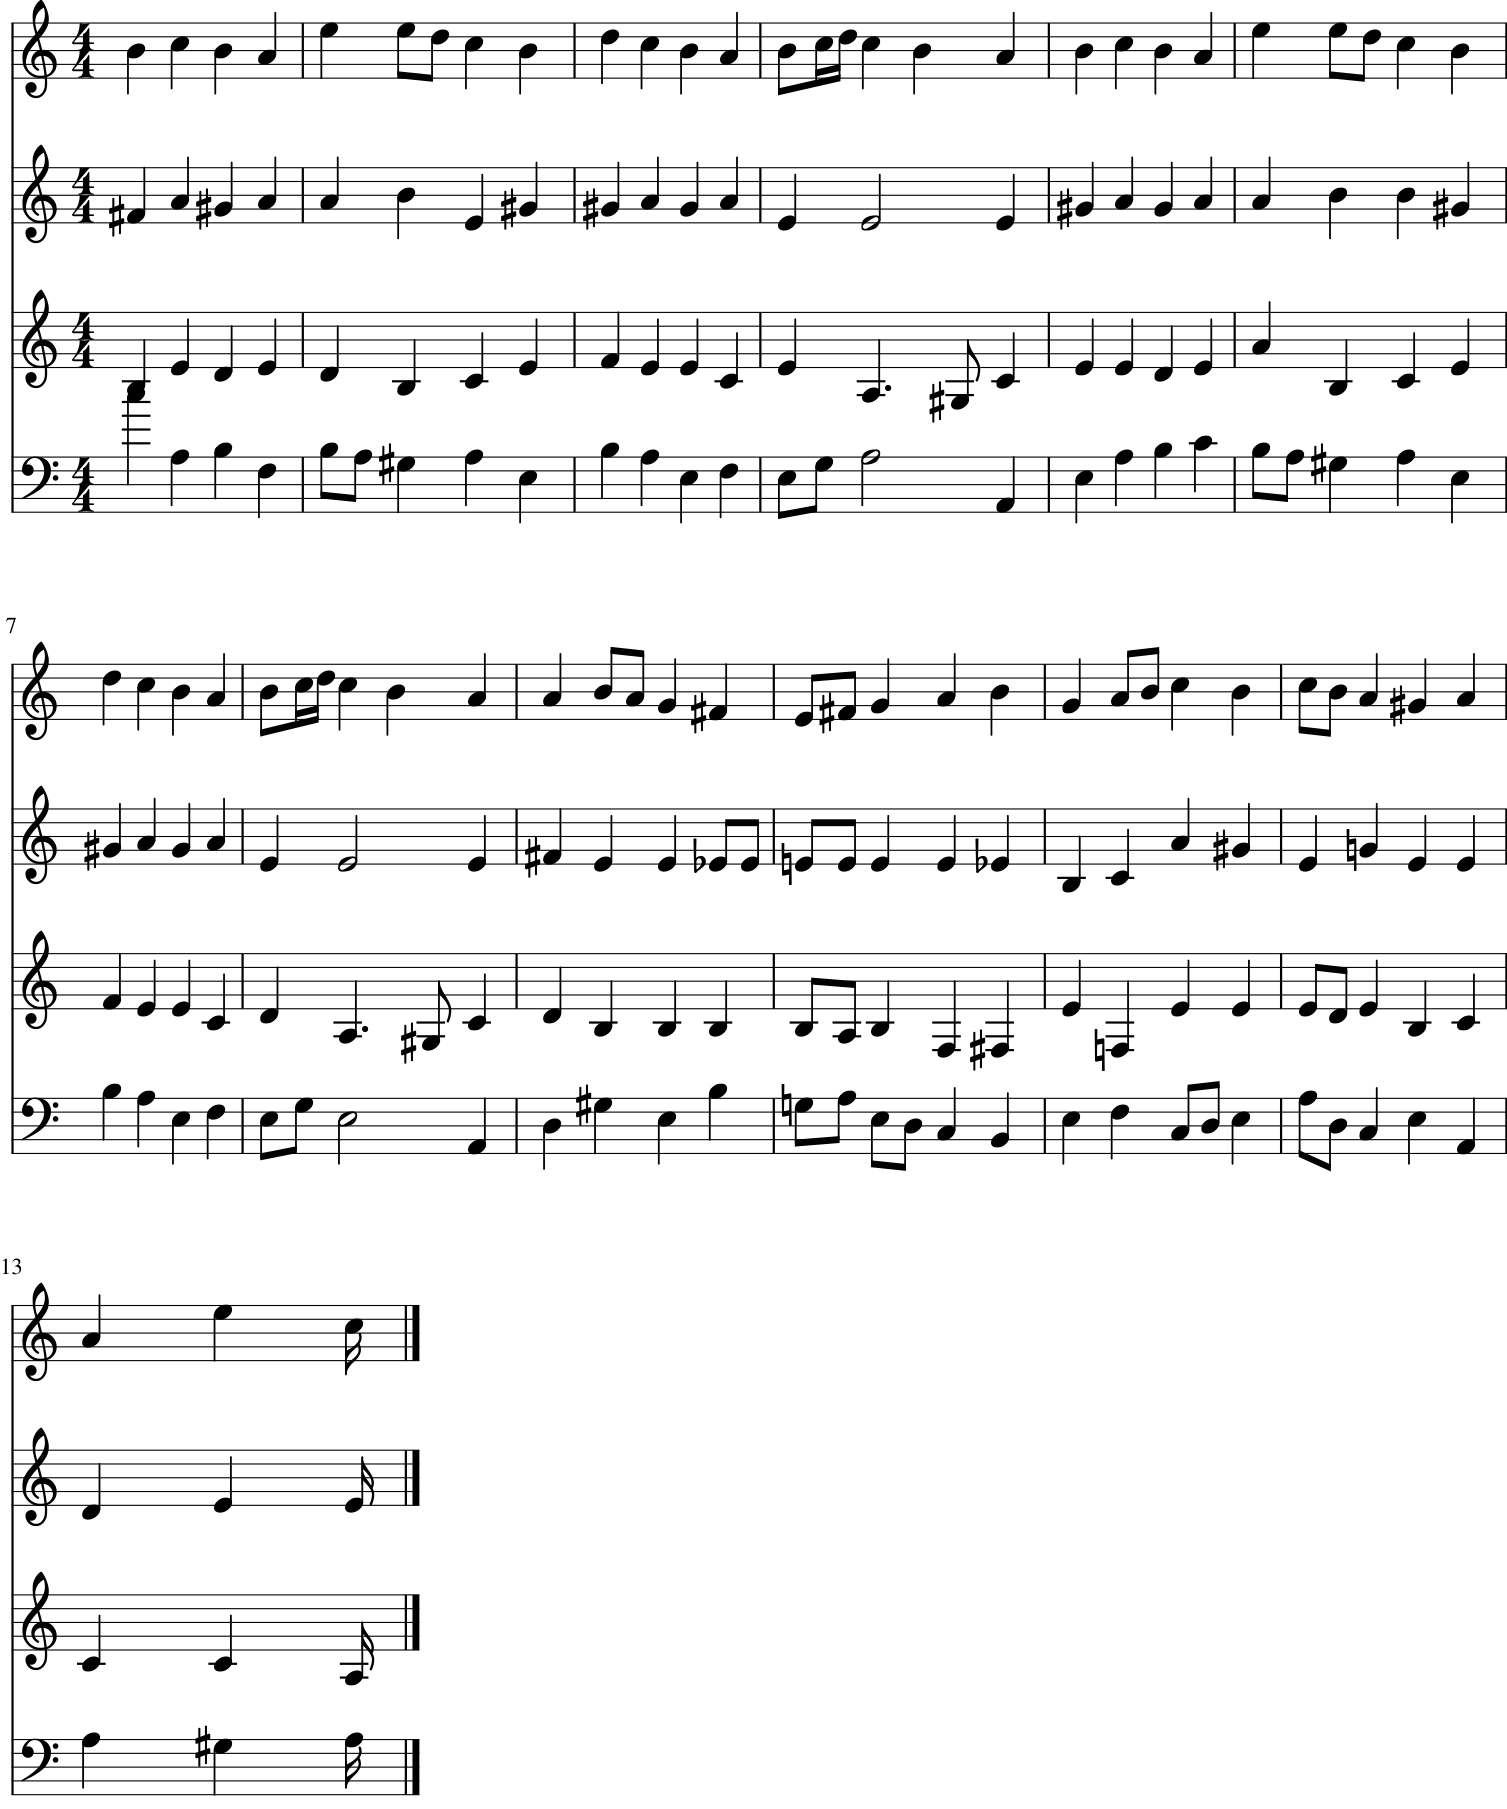

In [97]:
output_op = sess.graph.get_tensor_by_name(OUTPUT_NAME+":0")
print(output_op)
final_state_op = sess.graph.get_tensor_by_name(FINAL_STATES_NAME+":0")
print(final_state_op)
#copy_states_op = sess.graph.get_operation_by_name(COPY_STATES_OP_NAME)
#print(copy_states_op)
in_data = sess.graph.get_tensor_by_name(INPUT_NAME+":0")
in_states = sess.graph.get_tensor_by_name(INIT_STATES_NAME+":0")
#print(in_data)


predSongPieces = []
output = np.ndarray(shape=(1, 0, 6),  dtype=float)
states_data = np.zeros(final_state_op.shape)
print("sequence length: ", len(train['data'][0]))
for tick in range(len(train['data'][0])):
    tick_data = train['data'][0, tick]
    #print(tick_data)
    output_step, states_data = sess.run([output_op, final_state_op], {in_data : tick_data, in_states : states_data})
    #print(output_step)
    #_ = sess.run(copy_states_op, {in_data : tick_data})
    output = np.concatenate((output, output_step.reshape([1, 1, -1])), axis = 1)
    predSongPiece = export_dataset(songs, output)
    predSongPieces.append(predSongPiece[0])
        

songNum = 200 # song containing the first 16 ticks - the first measure
sc = createStream(predSongPieces[songNum], 4)
sc.show()
sc.show('midi')